In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def iterative_sigma_clip_mean(values, sigma=4.0, min_samples=10):
    """
    Calculates the mean of a bin after iteratively removing points 
    outside 4 standard deviations.
    """
    data = values.dropna().values
    
    # Initial check for sample size
    if len(data) < min_samples:
        return np.nan

    while True:
        if len(data) < min_samples:
            return np.nan
            
        avg = np.mean(data)
        std = np.std(data)
        
        # If variance is zero, we are converged
        if std == 0:
            return avg
            
        # Identification of outliers
        # "Data points falling more than 4 sigma from the average were deleted"
        lower_bound = avg - (sigma * std)
        upper_bound = avg + (sigma * std)
        
        mask = (data >= lower_bound) & (data <= upper_bound)
        
        # Check for convergence (no new outliers found)
        if np.all(mask):
            break
            
        # Filter and repeat
        data = data[mask]
            
    return np.mean(data)

In [12]:
def process_and_plot_rae_maps(df, frequency_col='frequency_band', 
                              ra_col='right_ascension', dec_col='declination', 
                              signal_col='rv1_coarse'):
    """
    Full pipeline: Cleans RAE-2 data, bins to 50x50, sigma-clips, and plots Mollweide.
    Assumes RA is in HOURS (0-24).
    """
    
    # Define the 50x50 Grid Edges (Degrees)
    # RA: 0 to 360, Dec: -90 to +90
    ra_bins_edge = np.linspace(0, 360, 51)
    dec_bins_edge = np.linspace(-90, 90, 51)
    
    # Process each frequency band separately
    grouped = df.groupby(frequency_col)
    
    for band, group in grouped:
        print(f"--- Processing Band: {band} ---")
        
        # Work on a copy to protect original dataframe
        data = group.copy().sort_index()

        # ---------------------------------------------------------
        # PRE-PROCESSING: Unit Conversion
        # ---------------------------------------------------------
        # User specified RA is in HOURS. Convert to DEGREES for the grid.
        data[ra_col] = data[ra_col] * 15.0

        # ---------------------------------------------------------
        # CLEANING STEP 1: Thermal Boom / Lunar Shadow (Oscillation)
        # ---------------------------------------------------------
        # "Exclude thermally induced boom-motion... Large 50-minute oscillations"
        # We use a rolling variance filter to detect these oscillations.
        
        rolling_std = data[signal_col].rolling('50min').std()
        rolling_mean = data[signal_col].rolling('50min').mean()
        
        # If std dev > 10% of signal, assume boom instability
        # (Adjust threshold 0.10 based on specific calibration data if needed)
        stable_mask = rolling_std < (0.10 * rolling_mean)
        data = data[stable_mask]
        
        # ---------------------------------------------------------
        # CLEANING STEP 2: Temporal-Gradient Veto
        # ---------------------------------------------------------
        # "Average signal levels in adjacent 10 minute intervals... 1.5 dB shift"
        
        # Resample to 10-min bins to match the "adjacent intervals" logic
        resampled = data.resample('10min').mean().dropna(subset=[signal_col])
        
        # Calculate dB shift: |10 * log10( current / previous )|
        prev_sig = resampled[signal_col].shift(1)
        db_shift = 10 * np.log10(resampled[signal_col] / prev_sig)
        
        # Keep intervals where shift is <= 1.5 dB
        valid_indices = resampled[abs(db_shift) <= 1.5].index
        
        # Filter our main data to only keep data occurring within these valid windows
        # (We use reindex -> ffill logic or just map the resampled data forward)
        # For mapping purposes, using the clean 10-min averages is standard.
        clean_data = resampled.loc[valid_indices].copy()

        # ---------------------------------------------------------
        # CLEANING STEP 3: Background Estimation & Clipping
        # ---------------------------------------------------------
        # "Estimate background over 4-day windows... +/- 2 dB"
        
        for i in range(2): # Iterative process (run twice)
            # Rolling 4-day mean (centered)
            bg_level = clean_data[signal_col].rolling('4D', center=True, min_periods=1).mean()
            
            # Compare signal to background in dB
            ratio = clean_data[signal_col] / bg_level
            diff_db = 10 * np.log10(ratio)
            
            # Clip data outside +/- 2 dB
            clean_data = clean_data[abs(diff_db) <= 2.0]

        # ---------------------------------------------------------
        # STEP 4: Grid Sorting & Iterative Sigma Clipping
        # ---------------------------------------------------------
        # "Sort RA/Dec into 50x50 grid... 4 sigma clipping... min samples 10"
        
        # Assign bins
        clean_data['ra_bin_idx'] = pd.cut(clean_data[ra_col], bins=ra_bins_edge, labels=False)
        clean_data['dec_bin_idx'] = pd.cut(clean_data[dec_col], bins=dec_bins_edge, labels=False)
        
        print(f"Applying 4-sigma clipping to {len(clean_data)} points... (this takes time)")
        
        # Group by pixel (Dec, RA) and apply the custom sigma clipper
        # This automatically "merges 4-day groups" as we are grouping the whole dataset by position
        pixel_values = clean_data.groupby(['dec_bin_idx', 'ra_bin_idx'])[signal_col].apply(
            iterative_sigma_clip_mean
        )
        
        # Reshape into 50x50 Matrix
        # Unstack creates a matrix where rows=Dec, cols=RA
        grid_map = pixel_values.unstack(level='ra_bin_idx')
        
        # Reindex to ensure we have exactly indices 0..49 (fills missing with NaN)
        grid_map = grid_map.reindex(index=range(50), columns=range(50))
        
        # ---------------------------------------------------------
        # PLOTTING: Mollweide Projection
        # ---------------------------------------------------------
        
        # 1. Create Coordinate Mesh
        # Calculate bin centers in degrees
        ra_centers = (ra_bins_edge[:-1] + ra_bins_edge[1:]) / 2
        dec_centers = (dec_bins_edge[:-1] + dec_bins_edge[1:]) / 2
        
        # 2. Convert to Radians & Shift RA
        # Mollweide expects x in [-pi, pi].
        # Our RA is 0..360.
        # Shift: (RA - 180) converts 0..360 to -180..180.
        ra_rad = np.radians(ra_centers - 180) 
        dec_rad = np.radians(dec_centers)
        
        # Meshgrid for pcolormesh
        RA, DEC = np.meshgrid(ra_rad, dec_rad)
        
        # 3. Plot
        fig = plt.figure(figsize=(12, 8))
        ax = plt.subplot(111, projection='mollweide')
        
        # Plot the matrix. grid_map.values matches the shape of RA/DEC mesh
        mesh = ax.pcolormesh(RA, DEC, grid_map.values, cmap='plasma', shading='auto')
        
        # 4. Formatting
        plt.colorbar(mesh, label='Antenna Temperature (Arbitrary/K)', orientation='horizontal', pad=0.05)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_title(f"RAE-2 Galactic Map\nBand: {band} | Grid: 50x50 | Clip: 4$\sigma$", fontsize=14)
        
        # 5. Fix X-Tick Labels to look like Astronomy (Hours)
        # The plot axis is technically -pi to pi (-180 to 180).
        # We want to label them as Hours: 0h..24h
        # Standard map: 180deg (center) is usually defined as 12h or 0h depending on convention.
        # If we shifted by 180, then x=0 (center) corresponds to RA=180 (12h).
        # x=-pi (left) corresponds to RA=0 (0h).
        # x=pi (right) corresponds to RA=360 (24h/0h).
        
        tick_locs = np.radians(np.arange(-150, 181, 30)) # Tick locations every 30 deg (2h)
        ax.set_xticks(tick_locs)
        
        # Create labels: Convert back to Hours
        # tick_locs (rad) -> deg -> +180 -> /15 -> hours
        tick_labels_deg = np.degrees(tick_locs) + 180
        tick_labels_hr = tick_labels_deg / 15.0
        ax.set_xticklabels([f"{int(h)}h" for h in tick_labels_hr])
        
        plt.show()

<>:132: SyntaxWarning: invalid escape sequence '\s'
<>:132: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1002469/2312686261.py:132: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"RAE-2 Galactic Map\nBand: {band} | Grid: 50x50 | Clip: 4$\sigma$", fontsize=14)


In [13]:
filename = r"/global/cfs/projectdirs/m4895/RAE2Data/interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)
start_date = pd.to_datetime("1974-01-01 14:00")
end_date = pd.to_datetime("1975-12-31 16:00")
data = data.loc[start_date:end_date]

--- Processing Band: 1 ---
Applying 4-sigma clipping to 1762 points... (this takes time)


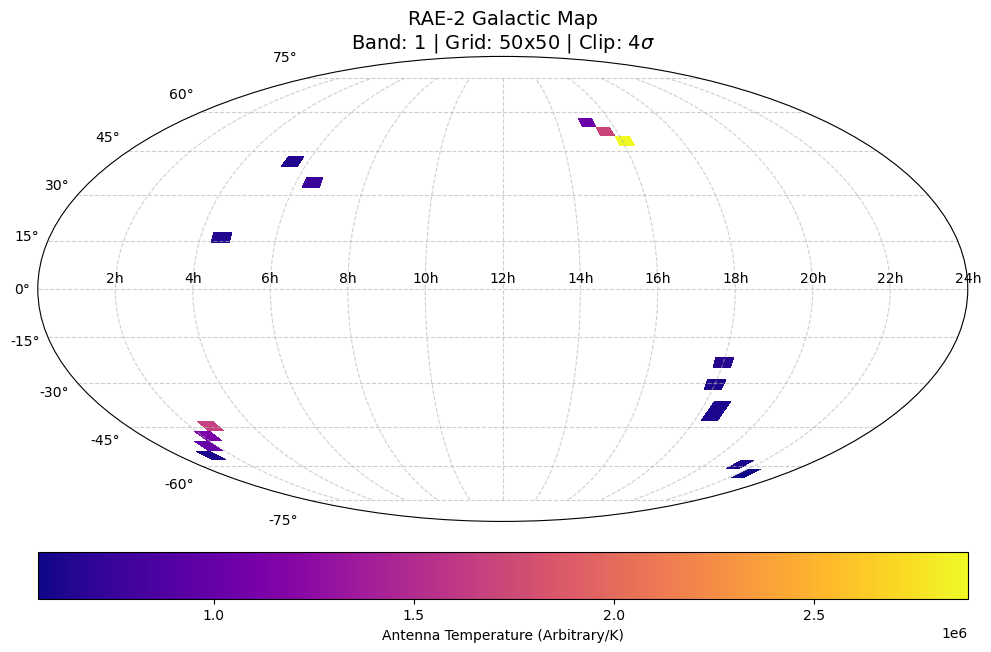

--- Processing Band: 2 ---
Applying 4-sigma clipping to 4119 points... (this takes time)


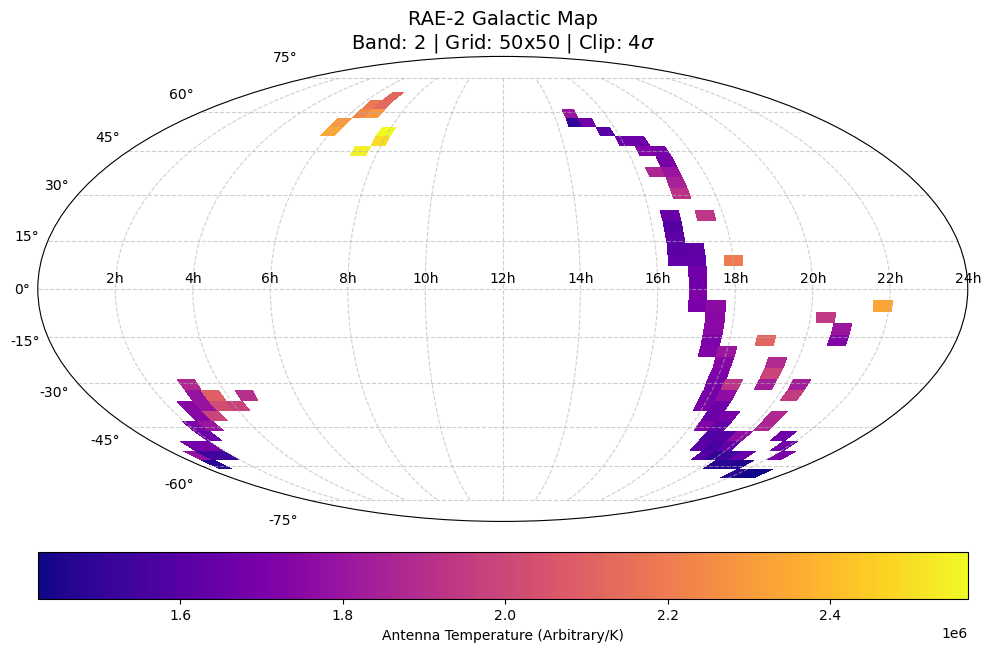

--- Processing Band: 3 ---
Applying 4-sigma clipping to 7423 points... (this takes time)


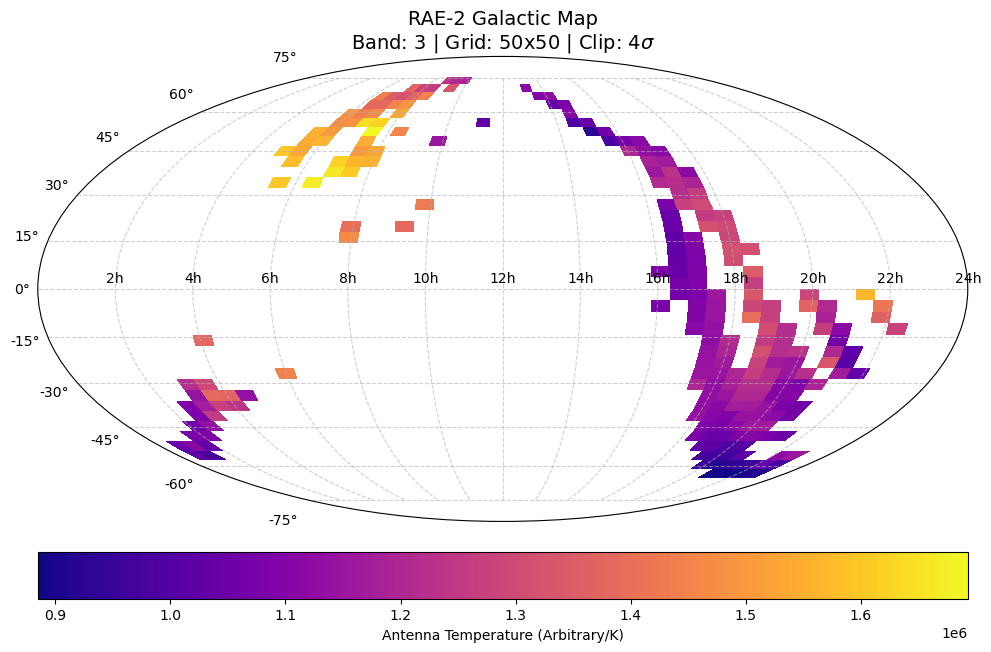

--- Processing Band: 4 ---
Applying 4-sigma clipping to 17812 points... (this takes time)


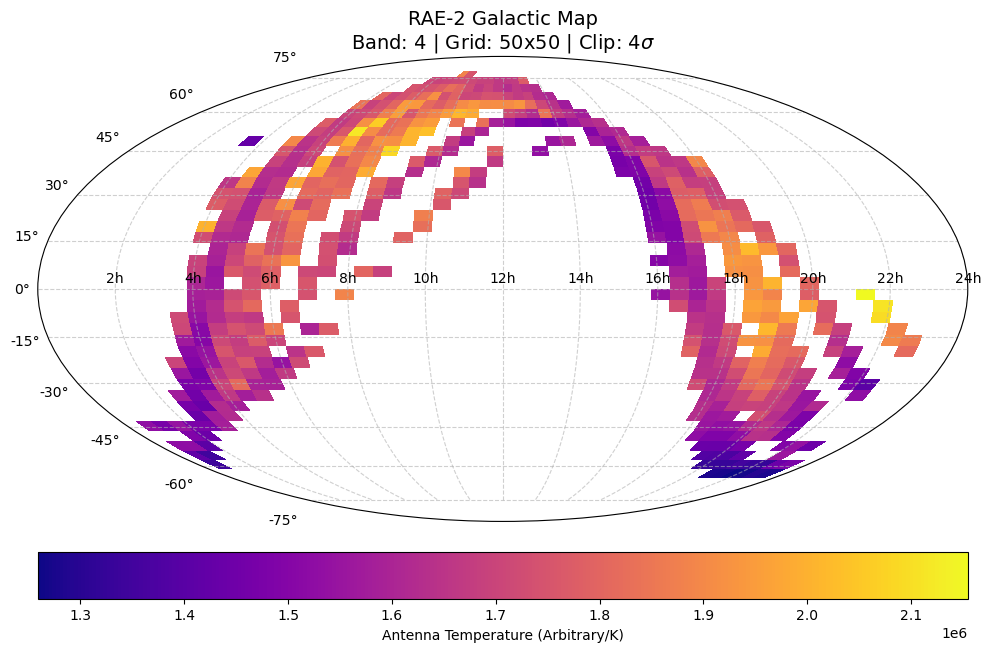

--- Processing Band: 5 ---
Applying 4-sigma clipping to 17113 points... (this takes time)


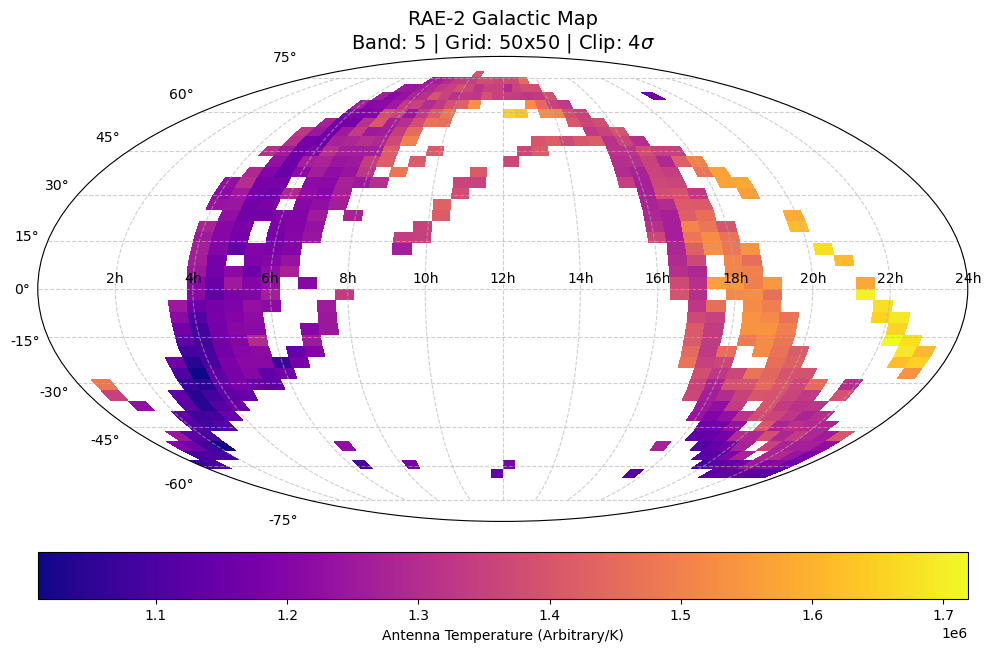

--- Processing Band: 6 ---
Applying 4-sigma clipping to 16423 points... (this takes time)


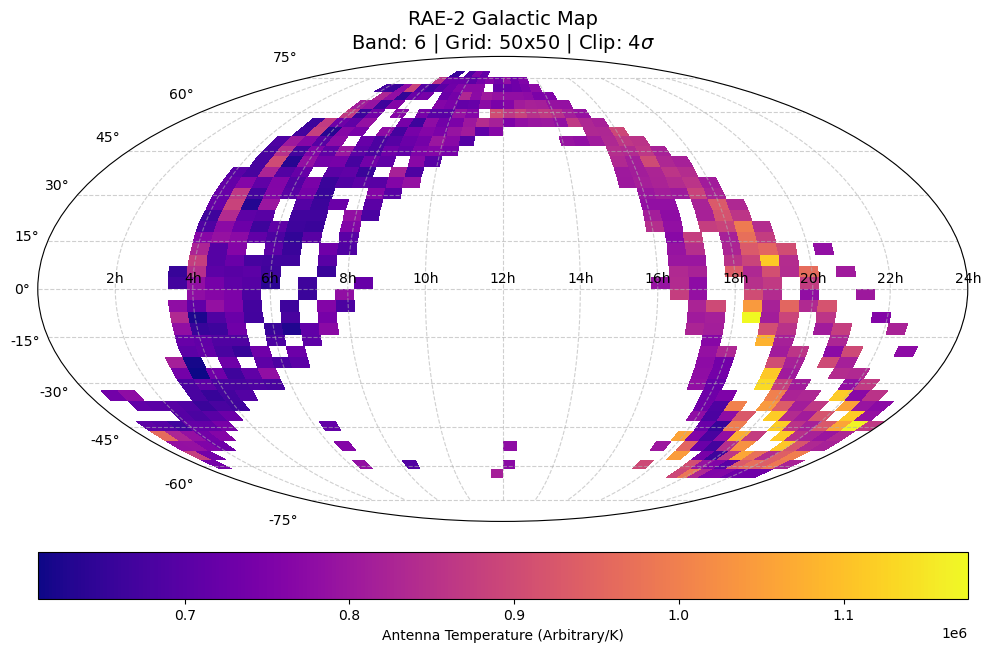

--- Processing Band: 7 ---
Applying 4-sigma clipping to 16319 points... (this takes time)


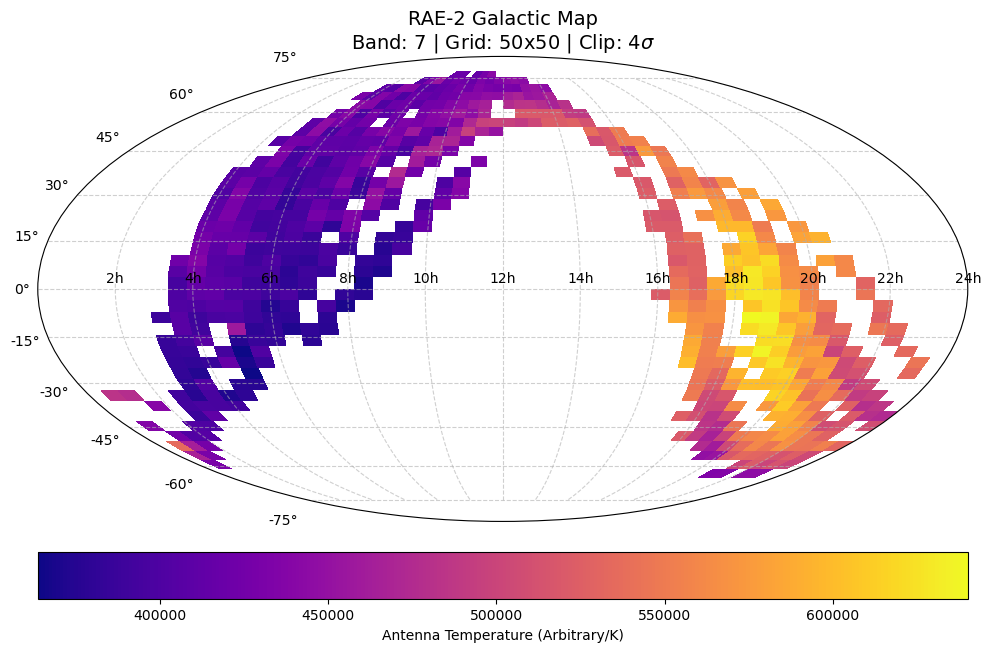

--- Processing Band: 8 ---
Applying 4-sigma clipping to 12582 points... (this takes time)


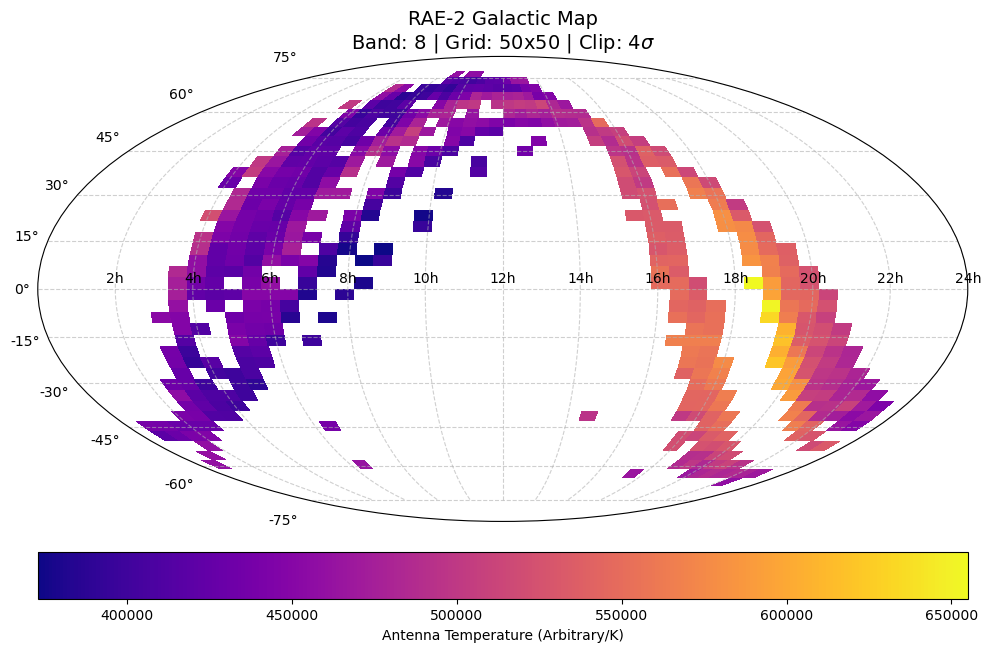

--- Processing Band: 9 ---
Applying 4-sigma clipping to 742 points... (this takes time)


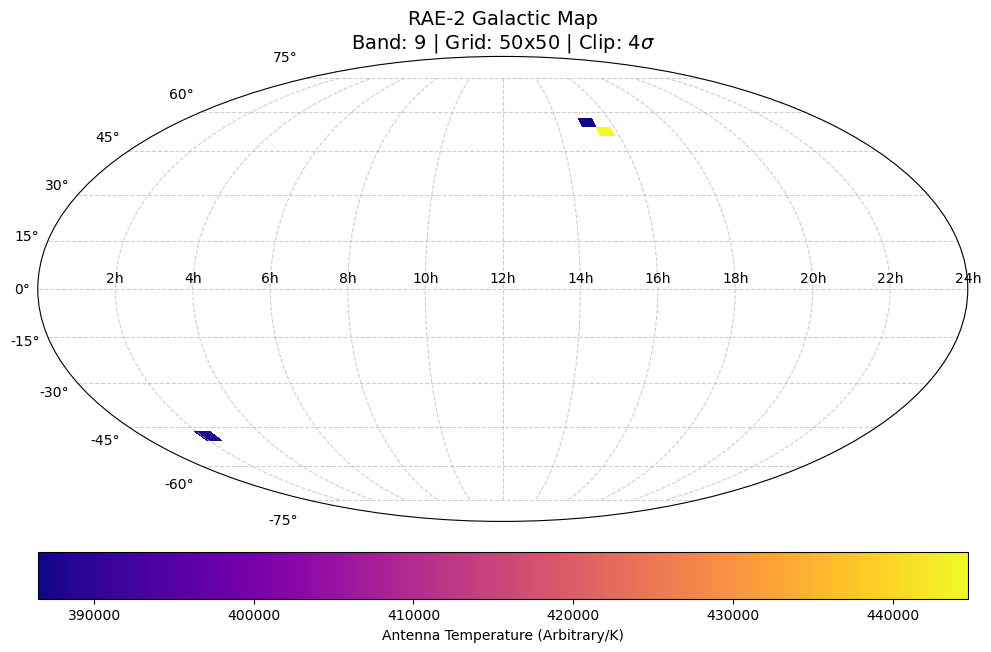

In [16]:
process_and_plot_rae_maps(data)